# Explore the Asheville Pub Safe Dataset

import python modules

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [74]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

read the raw data set from CSV file

In [2]:
df = pd.read_csv("APD_Public_Incident_Data__Crime_Locations.csv")

In [3]:
df.head()

,OBJECTID,incident_id,agency,date_occurred,case_number,address,geo_beat,geo_report_area,x,y,offense_short_description,offense_long_description,offense_code,offense_group_code,offense_group_level,offense_group_short_description,offense_group_long_description
0,109166,465432,APD,2011-02-28T14:32:50.000Z,11005427,100-BLK CHERRY ST N,AB1,A144,942560.94,691554.44,VANDALISM,VANDALISM,1400.0,14,Part II,VANDALISM,"To willfully or maliciously destroy, damage, d..."
1,109167,475711,APD,2011-05-17T20:11:31.000Z,11013040,100-BLK REDDICK RD/TUNNEL RD,AB3,A235,966852.31,686398.19,ROBARMKNIF,ROBBERY - ARMED - KNIFE,300.0,3,Part I,ROBBERY,"The taking, or attempting to take, anything of..."
2,109168,484416,APD,2011-06-18T00:00:00.000Z,11019448,100-BLK N MERRIMON AVE,WO3,WOD1,937907.31,706904.69,COMMTHREAT,COMMUNICATING THREAT,820.0,8,Part II,SIMPLE ASSAULT,An unlawful attack by one person upon another ...
3,109169,513630,APD,2012-02-23T00:00:00.000Z,12005489,100-BLK HAYWOOD ST/PAGE AVE,AC1,A151,943109.81,691159.38,INFOONLY,INFORMATION ONLY,9910.0,99,Part II,NON-REPORTABLE,Non-reportable (all other) offenses.
4,109170,514466,APD,2012-02-29T22:34:26.000Z,12006092,100-BLK KLONDYKE AVE,AB1,A127,937890.38,696501.75,COMMTHREAT,COMMUNICATING THREAT,820.0,8,Part II,SIMPLE ASSAULT,An unlawful attack by one person upon another ...


In [4]:
print("number of columns {}".format(len(df.columns)))
print("number of rows {}".format(df['OBJECTID'].count()))

number of columns 17
number of rows 99306


do we have dates?

In [5]:
df.date_occurred.dtype

dtype('O')

no -- lets convert

In [6]:
df['incident_dt'] = pd.to_datetime(df['date_occurred'])

In [7]:
df['incident_dt'].head(2)

0   2011-02-28 14:32:50
1   2011-05-17 20:11:31
Name: incident_dt, dtype: datetime64[ns]

all set -- lets use it as the index

In [8]:
df.index = df['incident_dt']

what kinds of offenses do we have?

In [9]:
df['offense_group_short_description'].value_counts()

LARCENY - THEFT                   27657
NON-REPORTABLE                    13769
SIMPLE ASSAULT                    10970
BURGLARY                          10039
FRAUD                              8368
VANDALISM                          5033
MOTOR VEHICLE THEFT                4874
DRUG/NARCOTIC OFFENSES             4518
ADDITIONAL OFFENSE CATEGORIES      3373
ALL OTHER OFFENSES                 2367
ROBBERY                            2359
AGGRAVATED ASSAULT                 1535
FORGERY AND COUNTERFEITING         1397
EMBEZZLEMENT                        955
DISORDERLY CONDUCT                  720
WEAPON LAW VIOLATIONS               579
STOLEN PROPERTY                     297
ARSON                               141
SEX OFFENSES                        139
CRIMINAL HOMICIDE                    60
OBSCENE MATERIAL / PORNOGRAPHY       57
OFFENSES AGAINST FAMILY              45
LIQUOR LAW VIOLATIONS                31
DRIVING WHILE IMPAIRED               11
PROSTITUTION OFFENSES                10


## larceny theft over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines larceny-theft as the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.

In [10]:
larceny_incidents = df[df['offense_group_short_description'] == 'LARCENY - THEFT']

In [11]:
larceny_incidents['incident_dt'].count()

27657

In [12]:
larceny_monthly_counts = larceny_incidents['offense_short_description'].resample('M').count()

In [13]:
larceny_monthly_counts.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

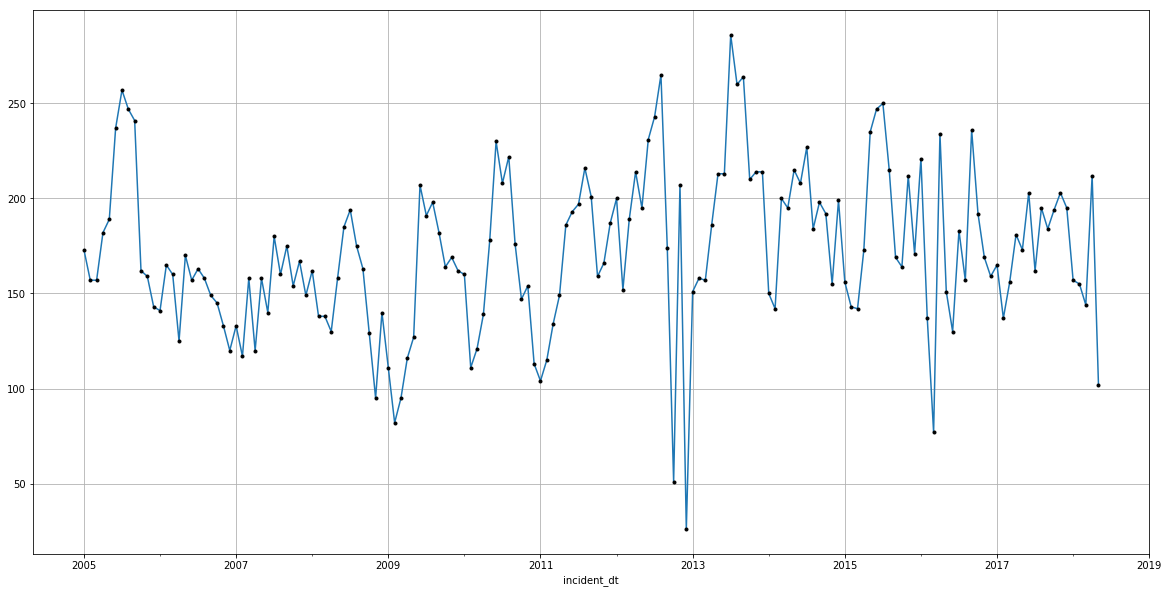

In [79]:
larceny_monthly_counts.plot()
larceny_monthly_counts.plot(style='k.', grid=True)

## Here we do a time series analysis

We decompose the data into three components:
- Trend over time
- Seasonal cycles 
- "Noise"/Randomness

In [53]:
larceny_result_add = seasonal_decompose(larceny_monthly_counts, model='additive')

## Plotting the overall trend

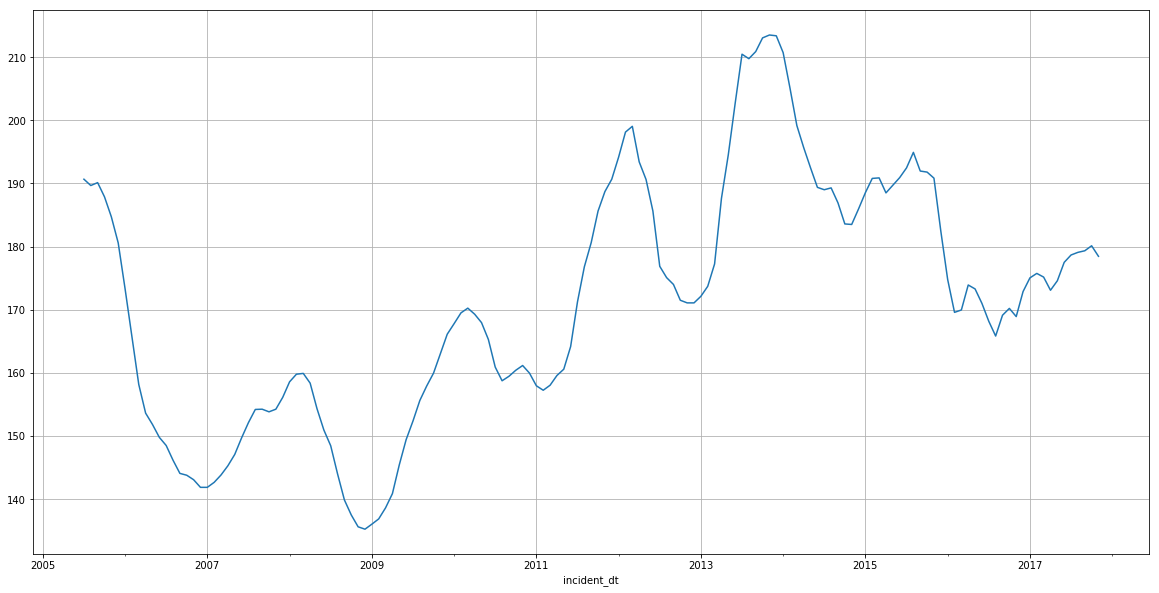

In [80]:
larceny_result_add.trend.plot(grid=True)

## Plotting the seasonal cycles

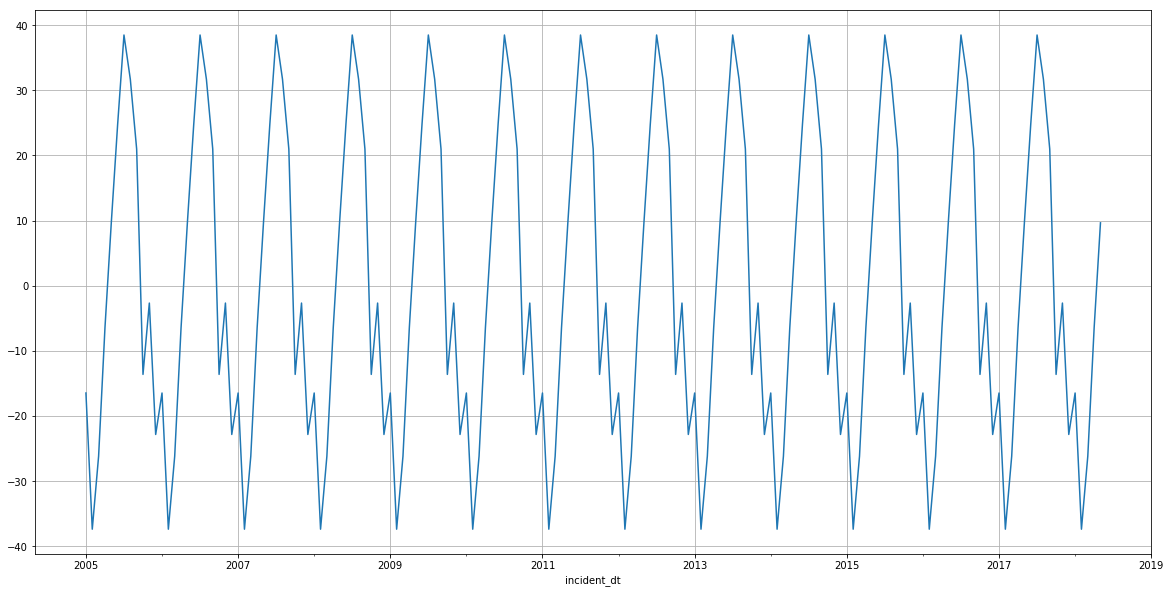

In [81]:
larceny_result_add.seasonal.plot(grid=True)

## ACF and PCF plots
Here we examine whether seasonal effects are statistically significant and at what lag they occur

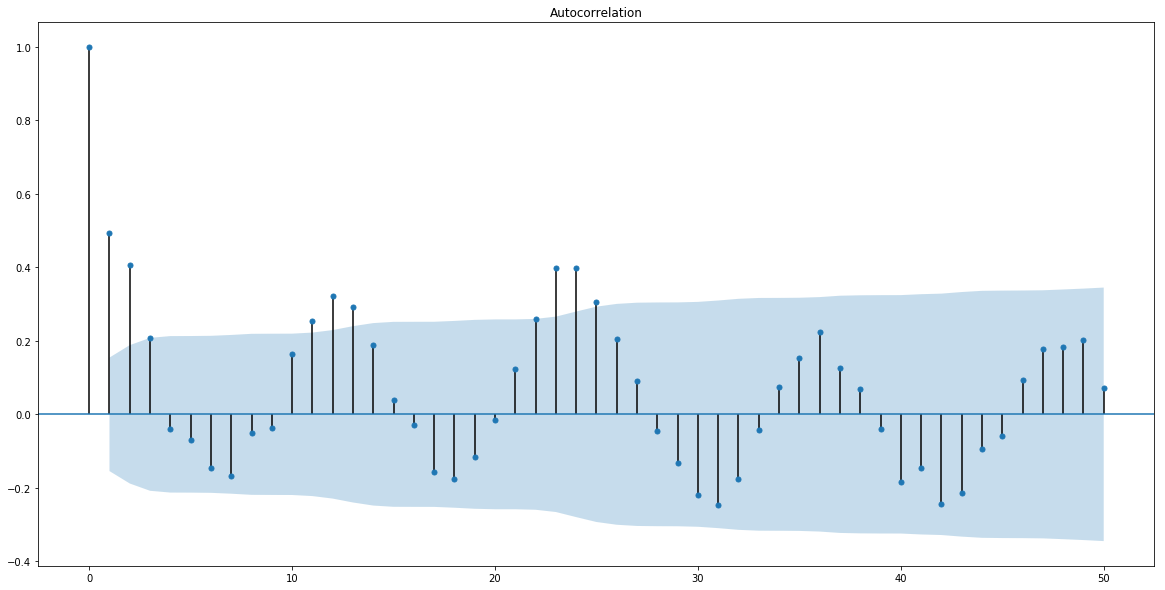

In [97]:
fig = plot_acf(larceny_monthly_counts, lags=50)

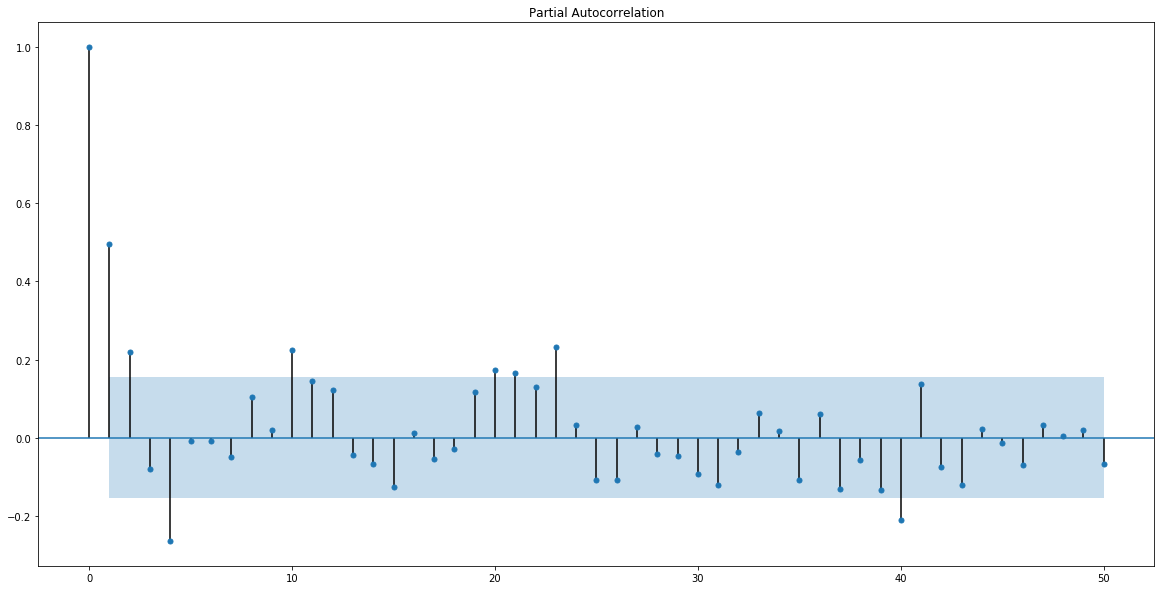

In [99]:
fig = plot_pacf(larceny_monthly_counts, lags=50)

Seasonal effects occur at a yearly cycle and are significant

## What is the peak value of the seasonal effect?

In [88]:
seasonal = larceny_result_add.seasonal

In [89]:
seasonal.max()

38.49225427350427

The model says that in the "bad months" seasonality adds 38 larcenies to the overall trend

In [96]:
seasonal.sort_values(ascending=False).head(5)

incident_dt
2010-07-31    38.492254
2017-07-31    38.492254
2016-07-31    38.492254
2012-07-31    38.492254
2011-07-31    38.492254
Name: offense_short_description, dtype: float64

The worst time for seasonal effects occurs at the end of July and the beginning of August

### Larceny peaks yearly approximately July 31st


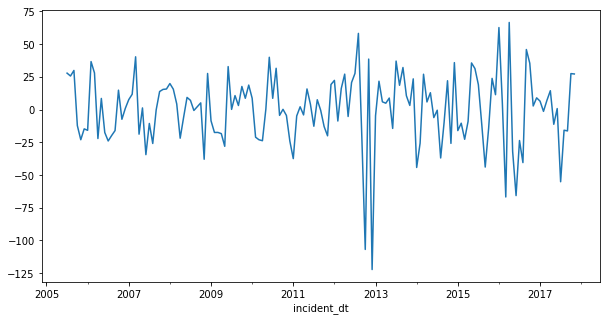

In [138]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
larceny_result_add.resid.plot()

In [140]:
mn = larceny_monthly_counts.mean()

In [141]:
shifted = larceny_result_add.seasonal.add(mn)

## Plotting seasonal effects on top of the raw data

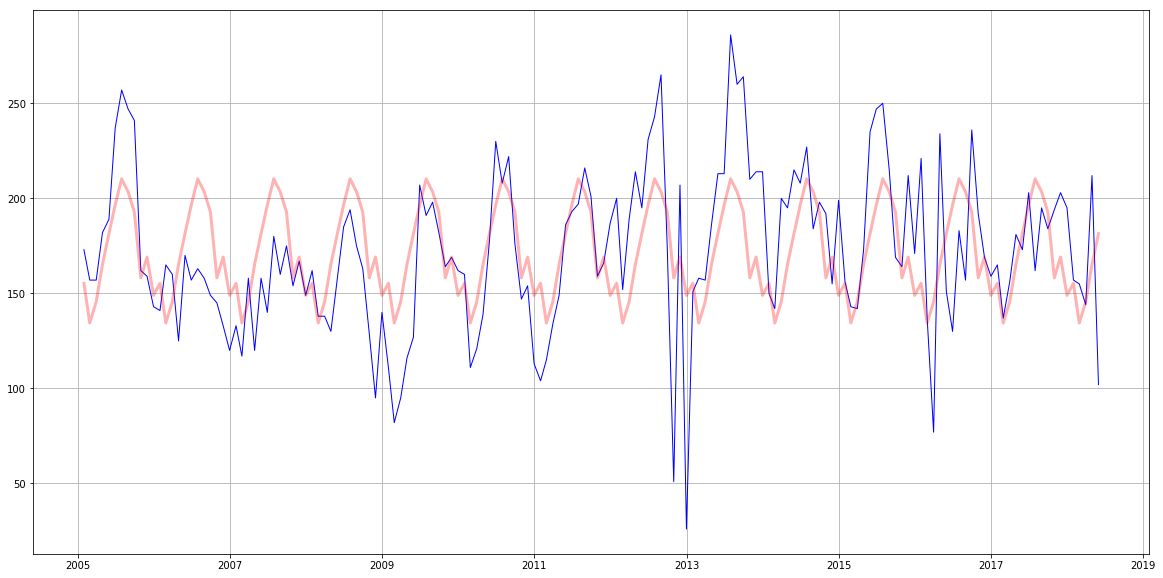

In [139]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.plot(larceny_monthly_counts, color='blue', linewidth=1)
plt.plot(shifted, color='red', linewidth=3, alpha=0.3)
plt.grid()
plt.show()

## Removing seasonality from the raw data and looking at trend

In [101]:
lar_no_season = larceny_monthly_counts - larceny_result_add.seasonal

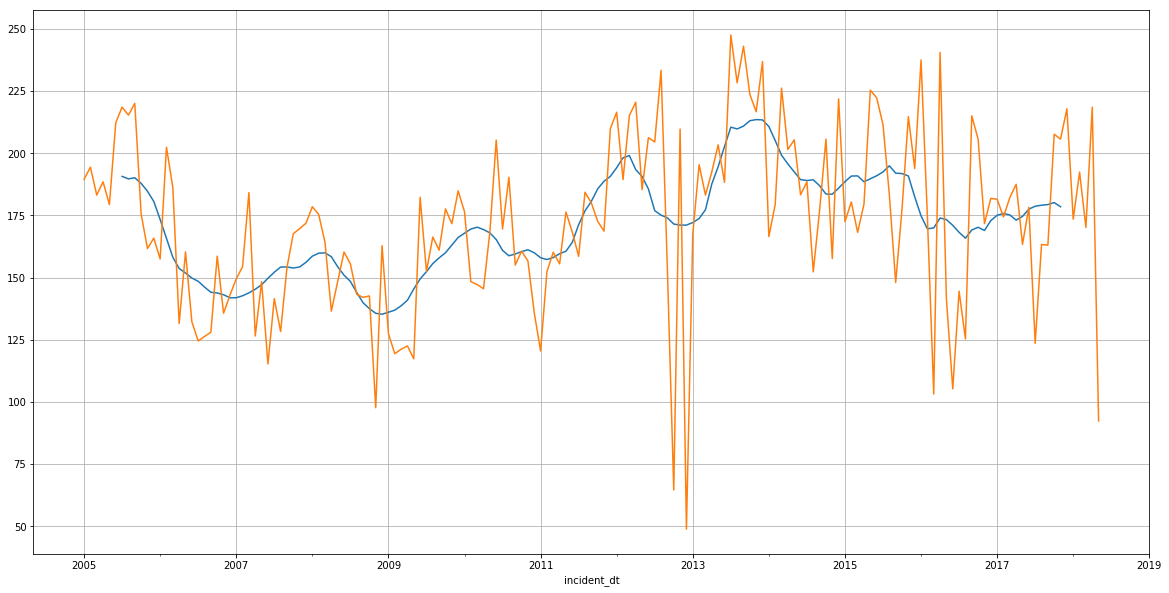

In [103]:
larceny_result_add.trend.plot(grid=True)
lar_no_season.plot(grid=True)

# Burglery over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines burglary as the unlawful entry of a structure to commit a felony or theft. To classify an offense as a burglary, the use of force to gain entry need not have occurred.

In [104]:
burgerly_incidents = df[df['offense_group_short_description'] == 'BURGLARY']

In [105]:
burgerly_incidents['incident_dt'].count()

10039

In [106]:
burgerly_monthly_counts = burgerly_incidents['offense_short_description'].resample('M').count()

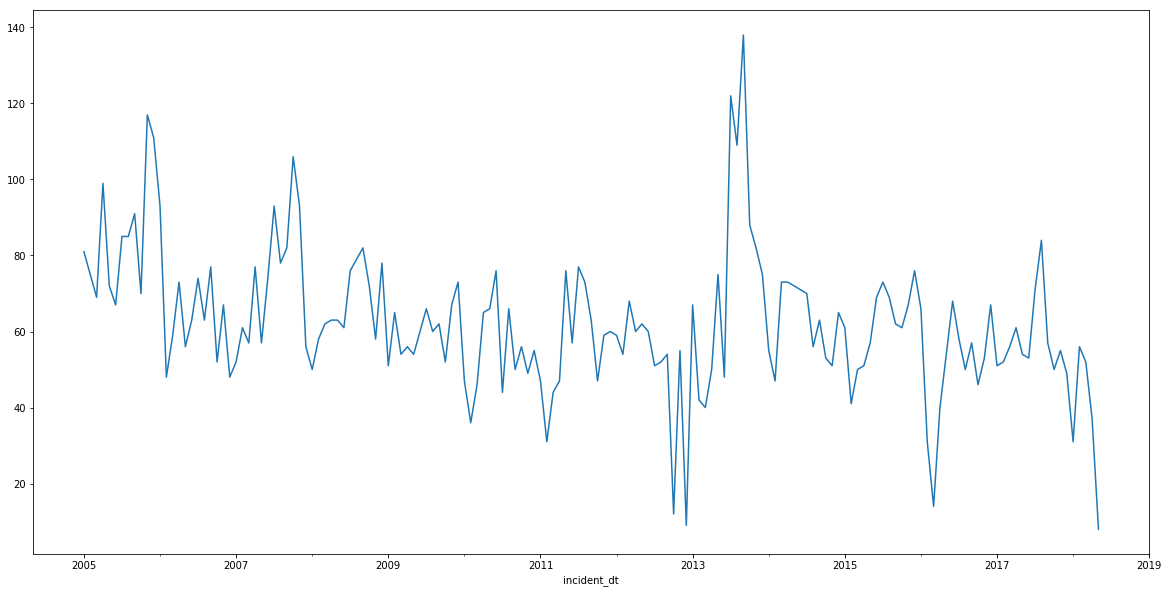

In [107]:
burgerly_monthly_counts.plot()

In [108]:
burgerly_result_add = seasonal_decompose(burgerly_monthly_counts, model='additive')

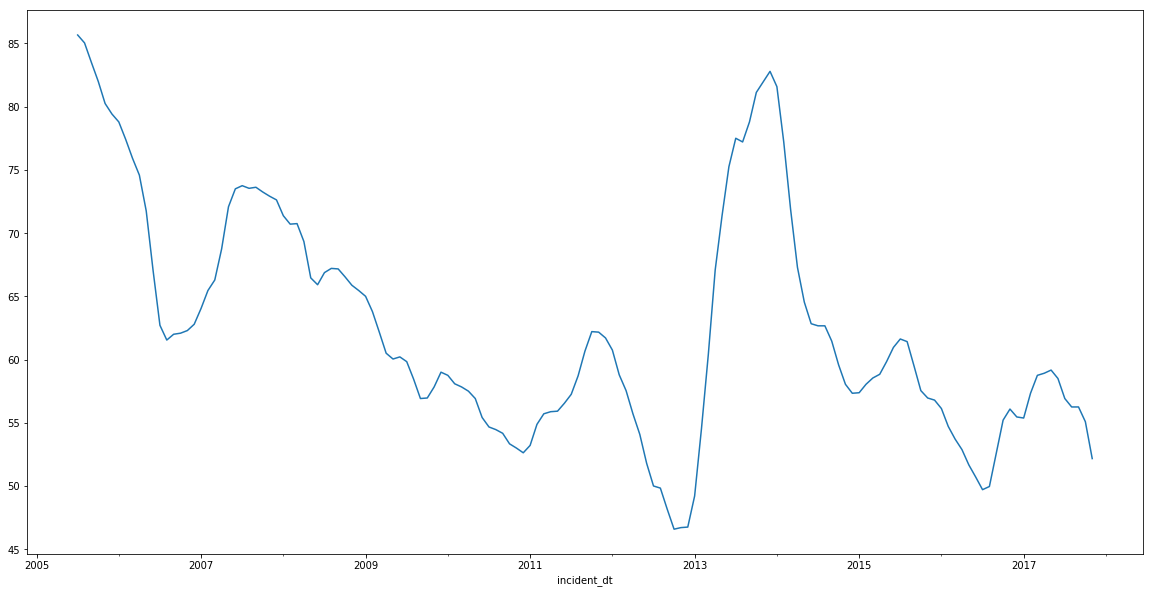

In [109]:
burgerly_result_add.trend.plot()

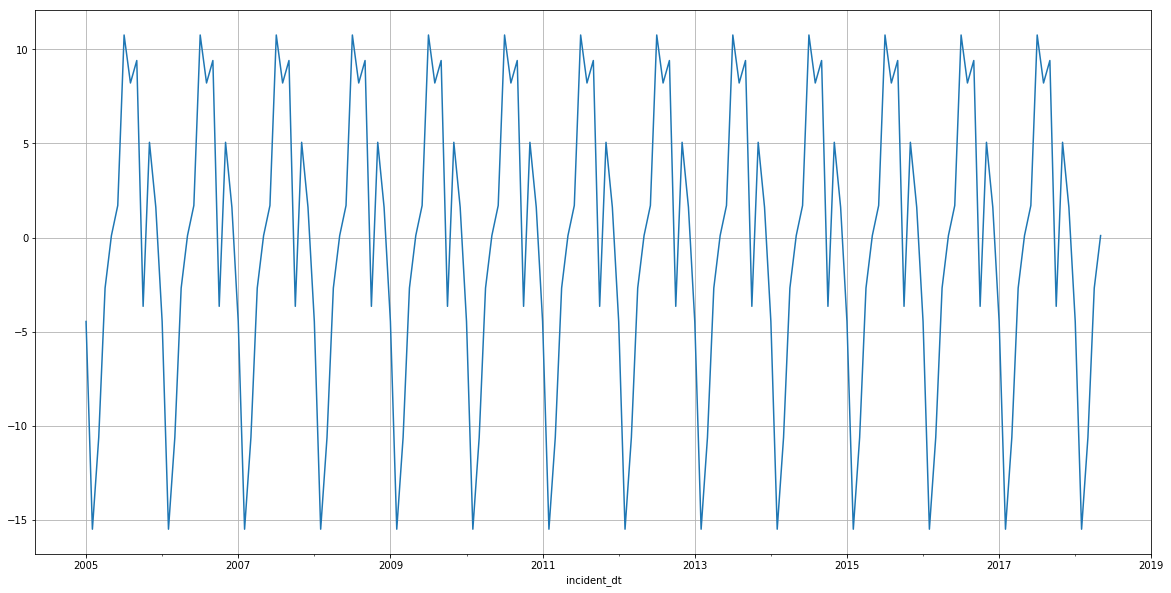

In [121]:
burgerly_result_add.seasonal.plot(grid=True)

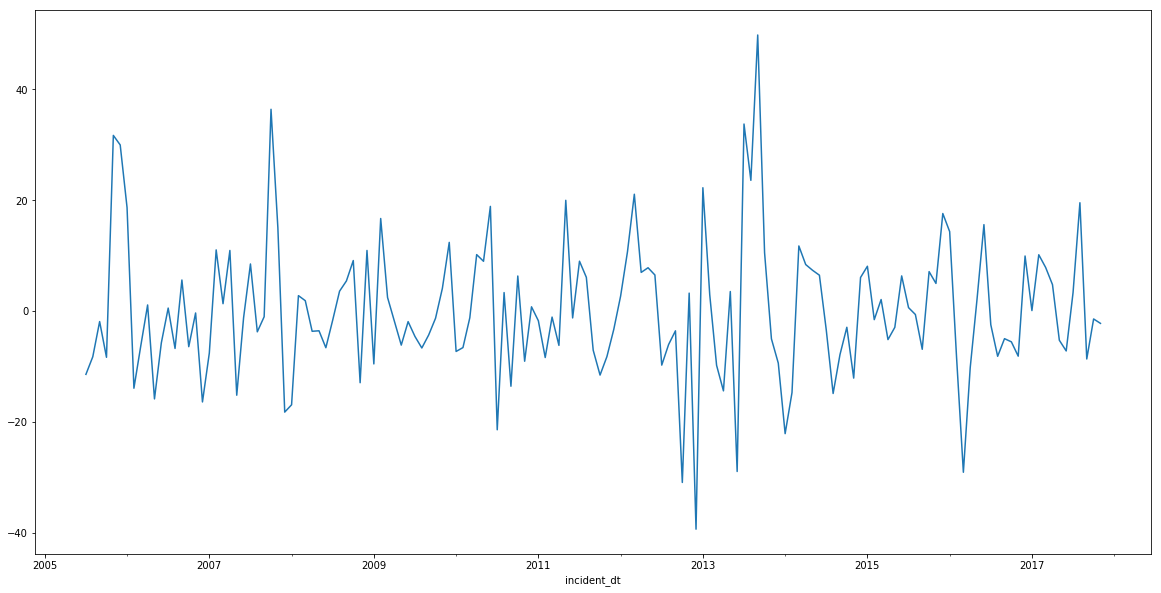

In [113]:
burgerly_result_add.resid.plot()

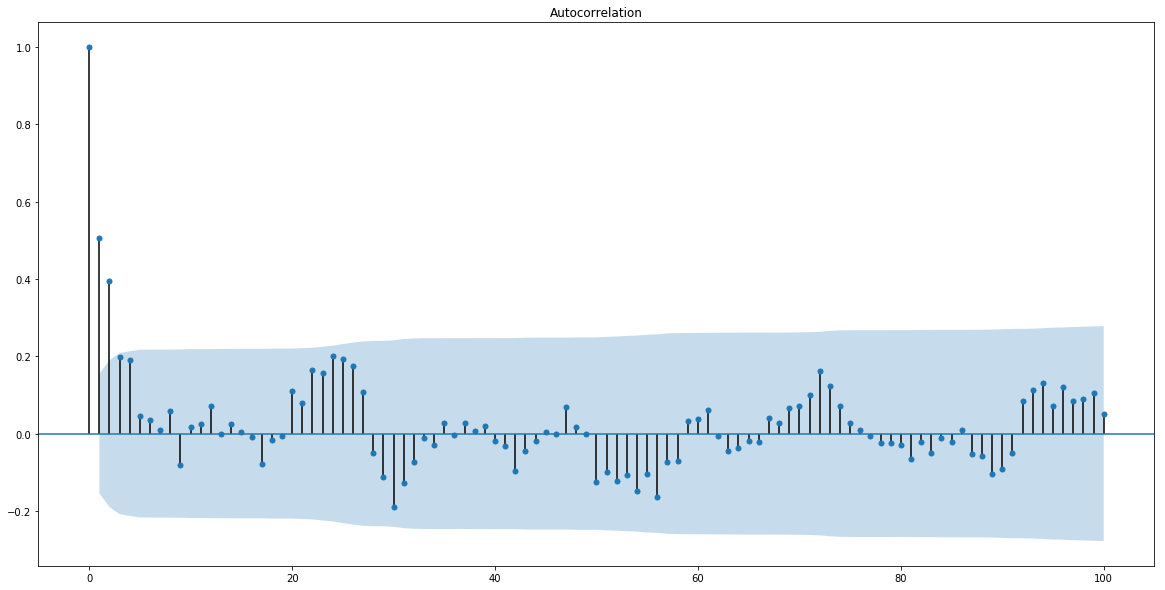

In [115]:
fig = plot_acf(burgerly_monthly_counts, lags=100)

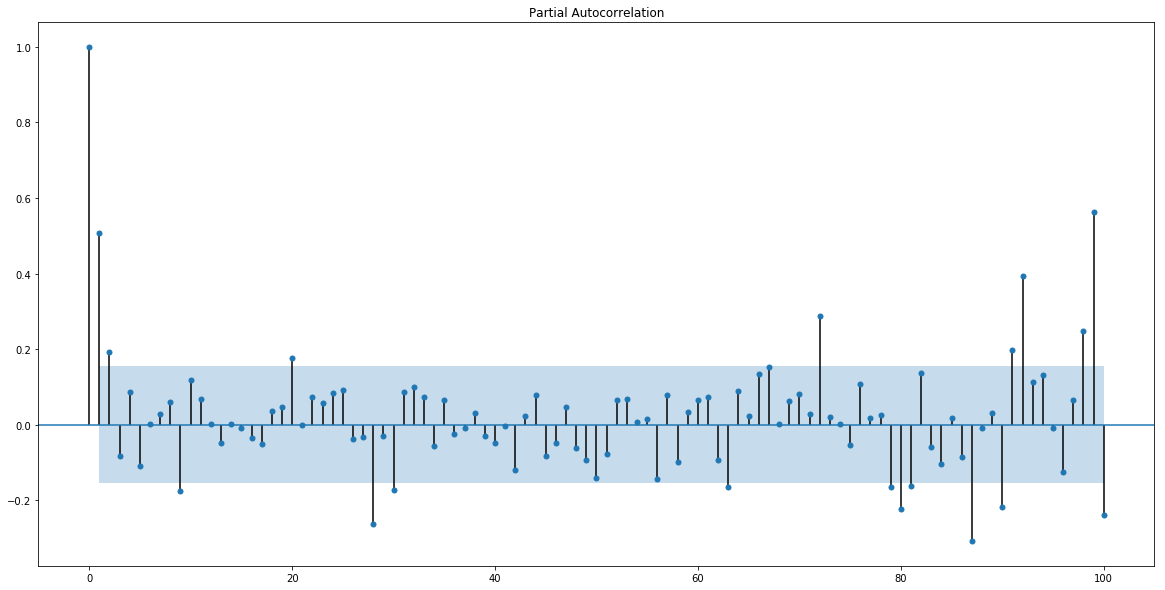

In [116]:
fig = plot_pacf(burgerly_monthly_counts, lags=100)

In [117]:
burg_seasonal = burgerly_result_add.seasonal

In [118]:
burg_seasonal.max()

10.761774394586892

In [120]:
burg_seasonal.sort_values(ascending=False).head(5)

incident_dt
2016-07-31    10.761774
2007-07-31    10.761774
2009-07-31    10.761774
2012-07-31    10.761774
2010-07-31    10.761774
Name: offense_short_description, dtype: float64

## burglery peaks every July 31

In [122]:
burg_seasonal.sort_values(ascending=True).head(5)

incident_dt
2008-02-29   -15.484753
2014-02-28   -15.484753
2007-02-28   -15.484753
2016-02-29   -15.484753
2009-02-28   -15.484753
Name: offense_short_description, dtype: float64

## and hits its minimum on Feb 28

In [123]:
burg_mn = burgerly_monthly_counts.mean()

In [124]:
burg_shifted = burg_seasonal.add(burg_mn)

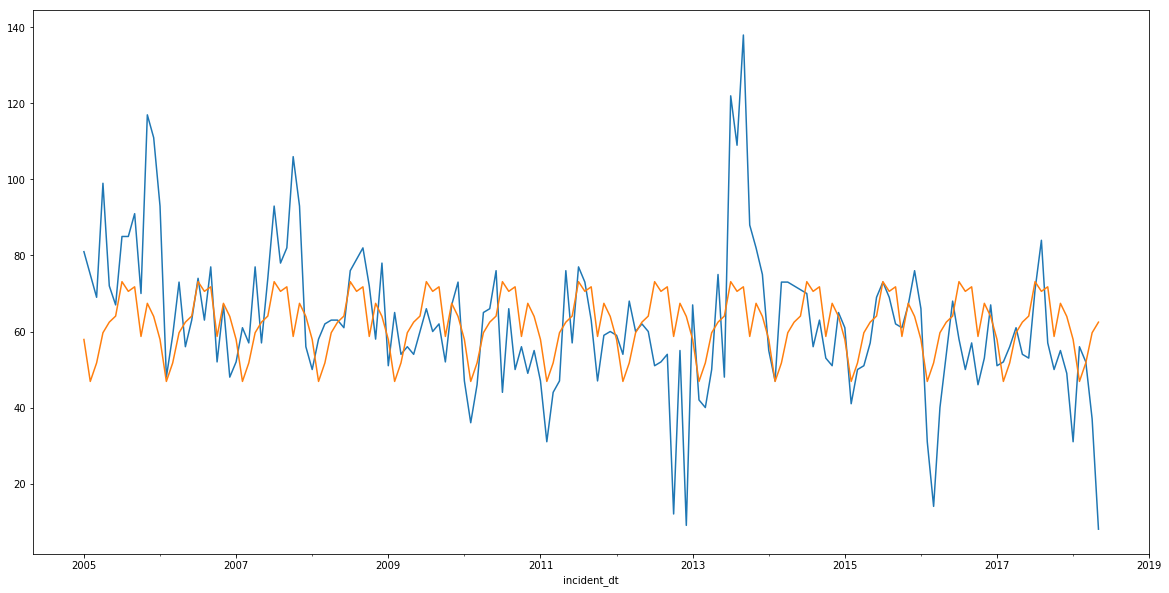

In [125]:
burgerly_monthly_counts.plot()
burg_shifted.plot()

In [136]:
shifted_zscore = (shifted - shifted.mean())/shifted.std()
burg_shifted_zscore = (burg_shifted - burg_shifted.mean())/burg_shifted.std()

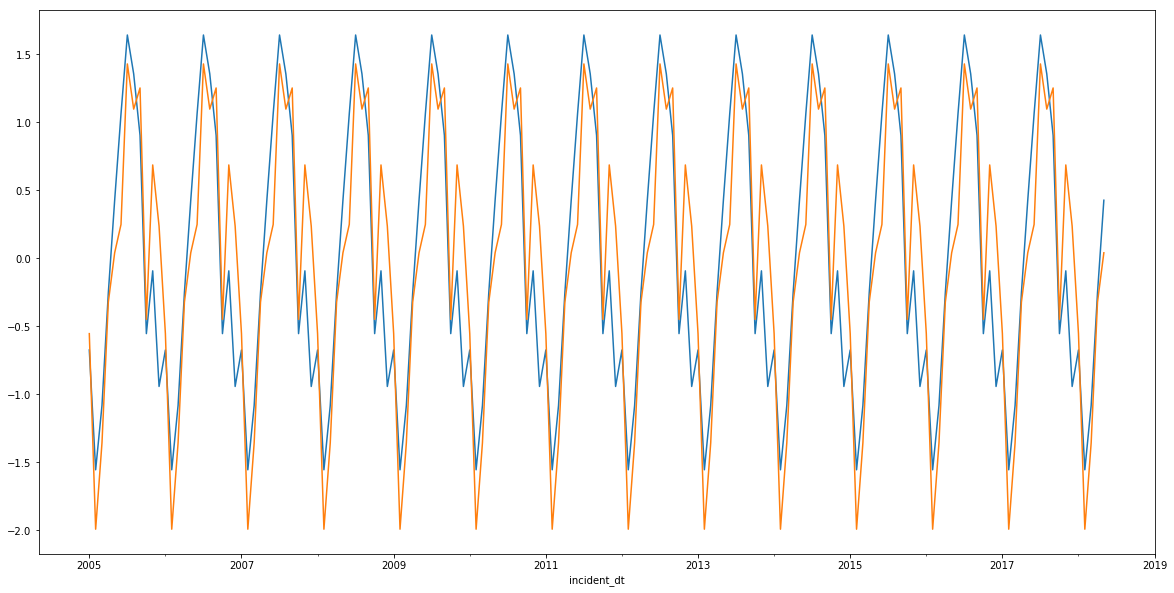

In [137]:
shifted_zscore.plot()
burg_shifted_zscore.plot()


Bele Chere was an annual music and arts street festival held in downtown Asheville, North Carolina. The festival was previously held annually on the last weekend in July[1][2] since 1979.[3] It was the largest free festival in the Southeastern United States,[4][5] attracting over 350,000 people.[1] The festival consisted of six stages scattered on various street corners in Asheville. A designated area called Arts Park typically featured several dozen regional artists and their work.[6] Displayed art covered a variety of media types including painting, photography, pottery and jewelry.[6] A variety of music genres were represented at the festival, including country, blues, folk, mountain, rock and jazz with both local and nationally known musicians represented. In 2013, the 35th annual Bele Chere festival was announced as the final festival by the City of Asheville.

A 2007 survey of businesses in downtown Asheville indicated that for more than 80% of respondents, the festival was bad for business, resulting in significant revenue declines during the days on which it is held. Two factors contributing to this were the large number of non-local vendors arriving for the event and the rise in vandalism during the festival. Despite this result, more than half felt that if the festival were to continue after 2007, it should remain where it is currently located. In 1979, the festival began as a way to bring needed revenue to downtown Asheville, which contained many vacant buildings and spaces; however, since the late 1970s the area has recovered and now is financially hurt by the event. 
